# AuxTel validation with CWFS test data from 210323 and 211104

Author: **Chris Suberlak** ([@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak))
<br>Last Verified to Run: **2022-05-03**
<br>Software Versions:
  - `ts_wep`: **v2.3.4**
  - `lsst_distrib`: **w_2022_16**
  
## Goal

Use test data from CWFS unit tests https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py, #L222, #L412 of commit d75a0bbdfc  , i.e. exposures 2021032300308 and  2021032300310 . The test values we are comparing against are: 
    
    # donuts pair 1 
    meas_zerns = [-19.40256, -51.19022, -11.11000]    # Measured[coma - X, coma - Y, focus] zernike 
    rot_zerns = [30.81990987, 45.24411764, -11.11000346]   # De - rotated zernike 
    hex_offsets = [0.14961121, -0.21963164, 0.0083452]
 
    # donuts pair 2 
    meas_zerns = [-5.156342491620025, 0.6554215087770965, -19.8341551660864]
    rot_zerns = [4.86354471, -1.83395149, -19.83415517]
    hex_offsets = [0.02360944, 0.00890268, 0.00449137]
    
Also, run the wavefront analysis for new  CWFS test data https://github.com/lsst-ts/ts_externalscripts/blob/7ab14e1cb82499d6da2afaa10fba014578e040c1/tests/auxtel/test_latiss_cwfs_align.py#L332 , commit 9f67ccc21419 i.e. exposures 2021110400954 and 2021110400955 . The test values are:
    
    
    meas_zerns = [-11.1, 14.5, -9.5, ]  # Measured [coma-X, coma-Y, focus] zernike coefficients [nm]
    rot_zerns = [-9.0, 15.9, -9.5, ]    # De-rotated [coma-X, coma-Y, focus]  zernike coefficients [nm]
    hex_offsets = [-0.044, -0.077, -0.004]   # Hexapod [x, y, z] offsets [mm]  
           

### Option A : using LSP 

After authenticating VPN, and opening a new machine on https://lsst-lsp-stable.ncsa.illinois.edu/ one can run this notebook on LSP, assuming that `lsst_distrib`, `ts_wep` and `ts_analysis_notebooks`  have been setup (for terminal commands such as pipetask), and same commands were added to the  `${HOME}/notebooks/.user_setups`  file that is sourced when starting the `LSST` jupyter kernel, for instance:
    
    setup lsst_distrib
    setup ts_wep -t $USER  -k -r /project/scichris/aos/ts_wep/
    setup ts_analysis_notebooks -k -r 
    
### Option B: tunneling jupyter notebook to a browser via SSH

Setup (that was used to run the analysis on a notebook opened in a browser using an ssh connection to the NCSA machine). Here `scichris` is my username, and `/project/scichris/aos/setup_aos_current.sh` the setup script that loads the AOS packages. In particular, the `ts_wep` installation used was `/project/scichris/aos/ts_wep` . The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the jupyter notebook.
    
Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    
Run in the NCSA terminal after DUO authentication (I aliased these in `~/.bash_profile`:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib     # first two aliased with "lsst"
    
    source /project/scichris/aos/setup_aos_current.sh  # aliased as "aos"
    
    setup -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    
    jupyter notebook --no-browser --port=54467         # aliased as "jup" 
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `$PATH_TO_TS_ANALYSIS_NOTEBOOKS` to open this notebook.


## Imports

In [ ]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

import numpy as np
from copy import copy
import yaml

from lsst.ts.wep.task.EstimateZernikesLatissTask import (EstimateZernikesLatissTask, 
EstimateZernikesLatissTaskConfig)
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.daf import butler as dafButler

from lsst.ts.analysis.notebooks import plotting_tools as pt

In [2]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Run the ISR 

Run the ISR: 

    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

On the `20210323` data:

    pipetask run  --data-query "exposure IN (2021032300307,2021032300308,2021032300309,2021032300310,2021032300311,2021032300312) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib --output u/scichris/Latiss/postISRtest2 --pipeline /project/$USER/aos/testLatiss4.yaml  --register-dataset-types
    
and on the `20211104` data:    
   
     pipetask run  --data-query "exposure IN (2021110400954,2021110400955) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib --output u/$USER/Latiss/postISRtest2 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types
  

Show the postISR:

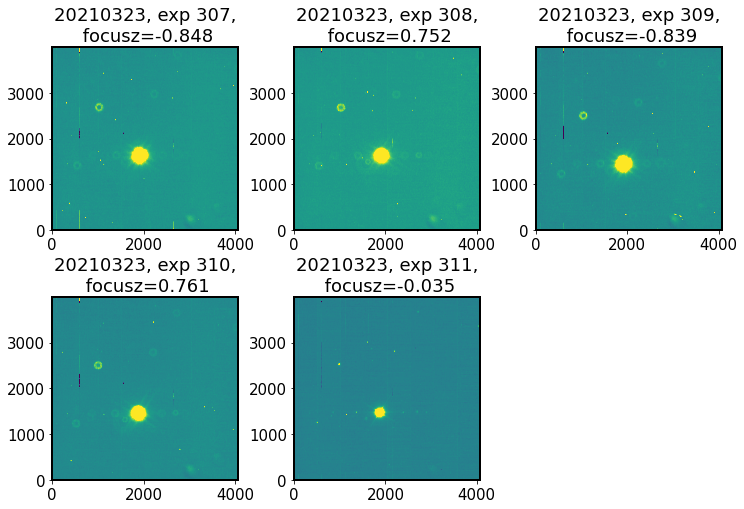

In [3]:
%matplotlib inline
pt.preview_exposures(year_month_day='20210323', exp_start=307, exp_end=312,
                    dataset_ref_or_type='postISRCCD',
                    collection="u/scichris/Latiss/postISRtest")

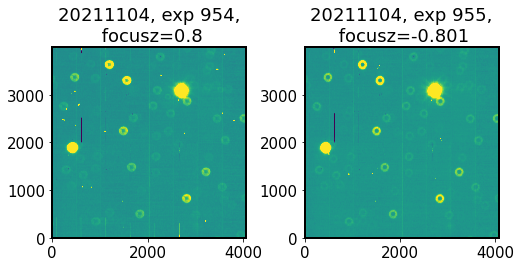

In [4]:
pt.preview_exposures(year_month_day='20211104', exp_start=954, exp_end=956,
                    dataset_ref_or_type='postISRCCD',
                    collection="u/scichris/Latiss/postISRtest2")

## Fit Zernikes

Run the donut detection via template fitting, and perform Zernike estimation. Store the results.

In [5]:
%matplotlib inline

def fit_zernikes_donut_template(path_to_repo = '/repo/main/', 
                                collection = 'u/scichris/Latiss/postISRex',
                                instrument = "LATISS",
                                detector = 0,
                                exp_intra = 2021090800487, 
                                exp_extra = 2021090800488
                                ):
    '''
    Fit for Zernike coefficients extra and intra-focal 
    exposure, by fitting donut template to find 
    source location. 
    
    Parameters
    ----------
    path_to_repo : str (optional)
        Path to butler repository containing the collection
        with postISR exposures
    collection: str (optional)
        Collection name containing the postISR in-focus exposure

        We assume just one collection containing all data.
        For Latiss tests a collection name
        can be "u/scichris/Latiss/test"
    instrument: str (optional)
        Name of instrument eg. LsstCam, LsstComCam, or LATISS
    detector: str or int (optional)
        Name of detector. For LATISS it is 0 , for
        LsstComCam eg. "R22_S10"   
    exp_intra: int (optional)
        Exposure number for intra-focal exposure
    exp_extra: int (optional)
        Exposure number for extra-focal exposure
        
    Returns:
    ---------
    fname: str
        Filename for pickled results.
    '''
    # initialize butler, load 
    # intra, extra exposures, and camera
    butler = dafButler.Butler(path_to_repo, instrument=instrument)
    exposure_intra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_intra
                                       },
                                collections=[collection]
                               )


    exposure_extra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_extra
                                       },
                                collections=[collection]
                               )

    camera = butler.get("camera",
                        dataId={"instrument": instrument}, 
                        collections=[collection],
                       )
    
    # find donuts from one of the exposures
    exposure = copy(exposure_intra)
    
    # run donut detect task
    donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend')
    donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)

    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra]
    
    # run estimate Zernikes task
    estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                             donutTemplateSize=200,
                                                             opticalModel='onAxis')
    estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store Zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{exp_intra}_{exp_extra}_n.npy'
    np.save(fname,zernikes, )
    print(f'Stored the results as {fname} ')
    
    return fname

Fit the data from `20210323`:

In [ ]:
fit_zernikes_donut_template(exp_intra=2021032300307, exp_extra=2021032300308,
             collection='u/scichris/Latiss/postISRtest',)

In [ ]:
fit_zernikes_donut_template(exp_intra=2021032300309, exp_extra=2021032300310,
             collection='u/scichris/Latiss/postISRtest',)

Fit the data from `20211104`:

In [ ]:
fit_zernikes_donut_template(exp_intra=2021110400954, exp_extra=2021110400955,
             collection='u/scichris/Latiss/postISRtest2',)

## Results

Plot the fit results, the test results, and the results of fitting the same data with `danish` (courtesy of J. Meyers) https://pypi.org/project/danish/#files https://github.com/jmeyers314/danish .


In [10]:
def compare_with_test(exp_start=307, exp_end=309, year='2021', month_day='0323', 
                      collection='u/scichris/Latiss/postISRtest',
                      test_results = [ [-19.40256, -51.19022, -11.11000],
                                    [-5.156342491620025, 0.6554215087770965, -19.8341551660864]],
                      test_zernike_idx = [8,7,4],
                      test_labels = ['pair1','pair2'],
                      test_colors = ['r','m'],
                      danish_results = [[-3104.618,17.177,134.087,-26.133,88.511,-20.925,14.620 ,41.928],
                                     [2951.144,24.803,161.688 ,-2.071,64.181,21.840,21.485,-38.272]
                                     ],
                      danish_labels = ['danish intra','danish extra'],
                      danish_colors = ['g','b']
                     ):
 
    fig = plt.figure(figsize=(14, 5))

    ####################################
    ### left - plot the fit results  ###
    #################################### 
    zk_start = 4
    
    test_idx_shifted  = np.array(test_zernike_idx)-zk_start
    
    ax1 = fig.add_axes([0,0,0.6,1])
    j=0
    for exp, label in zip([exp_start, exp_end], test_labels):
        zk_results_file = f'zerDic_{year}{month_day}00{exp}_{year}{month_day}00{exp+1}_n.npy'
        zk_results = np.load(zk_results_file, allow_pickle=True).item()
        zk_raw = zk_results['outputZernikesRaw'][0]
        for i in range(len(zk_raw)):
            zk_raw_nm = 1000*zk_raw[i]
            ax1.plot(np.arange(4, 23),zk_raw_nm, 
                     '-d', label=f'exp {exp}-{exp+1}, donut {i}')
            
        # calculate RMS error between CWFS test and ts_wep    
        zernikeErrors = np.sqrt((zk_raw_nm[test_idx_shifted]-test_results[j])**2.)
        zernikeRms = np.sqrt(np.mean(np.square(zernikeErrors)))
        print(f'For {label}, RMS difference is {zernikeRms}')
        j += 1 

    # plot the test results
    for coma_xy_focus, label, color in zip(test_results, 
                                           test_labels, 
                                           test_colors):
        ax1.scatter(test_zernike_idx, 
                    coma_xy_focus, 
                    c=color,
                    marker='d', s=100, 
                    zorder=10, label=label
                   )
    
    # plot danish results if available
    if len(danish_results)>0:
        for danish_result, label, color in zip(danish_results, 
                                               danish_labels, 
                                               danish_colors):
            ax1.scatter(np.arange(5,12), 
                        danish_result[1:], 
                        s=150, c=color, label=label)
            
    # add labels
    ax1.set_xlabel('Zernike Number',)
    ax1.set_ylabel('Zernike Coefficient [nanometers]', )
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()

    ax1.set_title(f'auxTel test data {year}{month_day}', fontsize=18)


    ###############################################
    ### right - plot the postISR image ###
    ###############################################

    ax2 = fig.add_axes([0.6,0,0.4,1])
    butler = dafButler.Butler('/repo/main/')
    datasetRefOrType='postISRCCD'
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                                 'exposure':int(f'{year}{month_day}00{exp}')
                                                    }, collections=[collection])
    zscale = ZScaleInterval()
    data = exposure_intra.image.array
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

    donutStamps = zk_results['donutStampsExtra'][0]
    nrows = len(donutStamps)
    for i in range(nrows):
        donut = donutStamps[i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    ax2.set_title(f'exp{exp}')

For test pair1, RMS difference is 29.502233923195405
For test pair2, RMS difference is 24.138414691640016


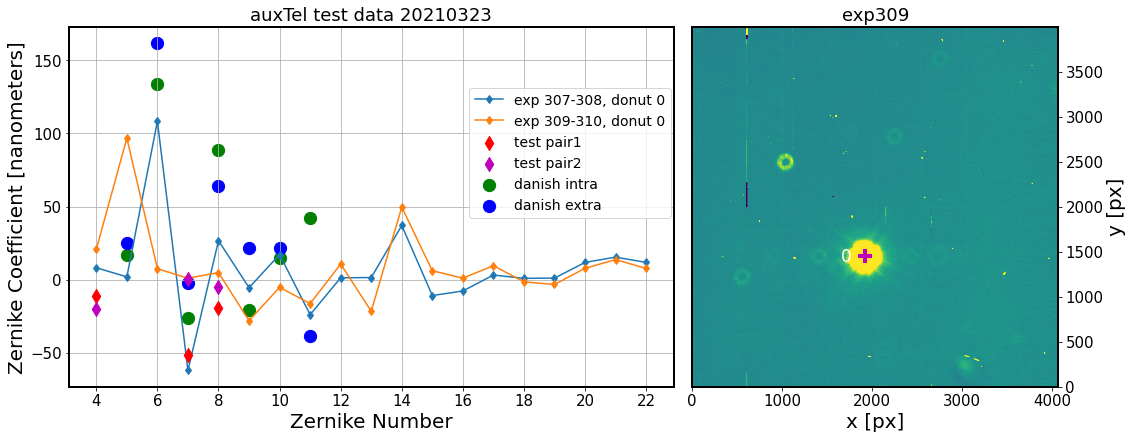

In [11]:
compare_with_test(exp_start=307, exp_end=309, year='2021', month_day='0323', 
                  test_results = [ [-19.40256, -51.19022, -11.11000],
                                [-5.156342491620025, 0.6554215087770965, -19.8341551660864]],
                  test_labels = ['test pair1','test pair2'], 
                  test_colors = ['r','m'],
                  danish_results = [[-3104.618,17.177,134.087,-26.133,88.511,-20.925,14.620 ,41.928],
                                 [2951.144,24.803,161.688 ,-2.071,64.181,21.840,21.485,-38.272]
                                 ],
                  danish_labels = ['danish intra','danish extra'],
                  danish_colors = ['g','b']
                 )


For test, RMS difference is 89.2798019702545


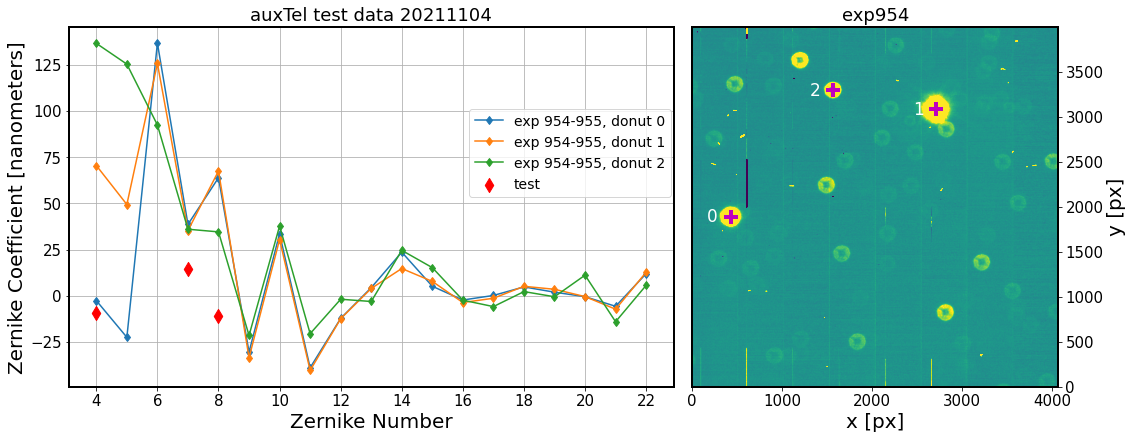

In [12]:
compare_with_test(exp_start=954, exp_end=954, year='2021', month_day='1104', 
                  collection='u/scichris/Latiss/postISRtest2',
                  test_results = [ [-11.1, 14.5, -9.5, ]],
                  test_labels = ['test'], 
                  test_colors = ['r'],
                  danish_results = []
                 )

For the April 2021 data, the test RMS difference was between 24 and 29 nm, while for November 2021 data the RMS difference was 89 nm. This is well within the 200 nm error budget allocated by Manuel+2010 https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-2-1528&id=194529 . However, given that  only three Zk values are measured by the CWFS test, this test is limited in scope. 